In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')  

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pytz
from pytz import common_timezones, all_timezones
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
from datetime import datetime
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
matplotlib.style.use('fivethirtyeight')
matplotlib.style.use('seaborn-talk')

This ipython notebook will illustrate the matching methodology we will use to match patients in the SEER-Medicare linked database. The comparison between patient outcomes between those patients who receive proton beam therapy vs traditional radiation therapy requires as a first step a matching of the two different groups. One method to perform this matching is to use Propensity Score Matching. Here we are going to illustrate a more direct method of matching using KDTrees, a data structure that allows for efficient finding of nearest neighbors in high-dimenional space.

We will first identify all patients with left-sided breast cancer, using the following primary site codes:
(C500-506, C508-C509) AND only consider left breast cases: LATERALITY == "Left: origin of primary" coded as 2.
Then we will split the above patient population into two groups as follows: The treatment group, defined as the patients receiving any form of radiation the control group, defined as the patients who did not receive any form of radiation Operationally, these groups are defined by looking at the column RADIATN, which has values:


| Code	| Description |
|:---------:|:--------------:|
|0	| None; diagnosed at autopsy |
|1	|Beam radiation |
|2	|Radioacative implants|
|3	|Radioisotopes|
|4	|Combination of 1 with 2 or 3|
|5	|Radiation, NOS - method or source not specified|
|6	|Other radiation (1973-1987 cases only)|
|7	|Patient or patient's guardian refused radiation therapy|
|8	|Radiation recommened, unknown if administered|
|9	|Unknown if radiation administered|


So that a value of 0 defines the control group, and the values (1,2,3,4,5,6) define the treatment group. We will then perform matching between the resulting treatment and control groups.

In [3]:
import seerhelp
breastfiles = seerhelp.get_breastfiles()
breastfiles

['SEER_1973_2013_TEXTDATA\\incidence\\yr1973_2013.seer9\\BREAST.TXT',
 'SEER_1973_2013_TEXTDATA\\incidence\\yr1992_2013.sj_la_rg_ak\\BREAST.TXT',
 'SEER_1973_2013_TEXTDATA\\incidence\\yr2000_2013.ca_ky_lo_nj_ga\\BREAST.TXT',
 'SEER_1973_2013_TEXTDATA\\incidence\\yr2005.lo_2nd_half\\BREAST.txt']

In [4]:
import seerhelp
breastfiles = seerhelp.get_breastfiles()
breastfiles

dfbreast0 = seerhelp.make_clean_dataframe(breastfiles[0])
dfbreast1 = seerhelp.make_clean_dataframe(breastfiles[1])
dfbreast2 = seerhelp.make_clean_dataframe(breastfiles[2])
dfbreast3 = seerhelp.make_clean_dataframe(breastfiles[3])

dfbreast = pd.concat([dfbreast0, dfbreast1, dfbreast2,
                     dfbreast3], ignore_index=True)

#dfother = pd.concat([dfother0, dfother1,dfother3], ignore_index=True)

print(dfbreast.shape)

del dfbreast0
del dfbreast1
del dfbreast2
del dfbreast3

(1448798, 141)


In [5]:
dfbreast.LATERAL.value_counts()

Left origin of primary                                                        730569
Right origin of primary                                                       702454
Paired site, but no information concerning laterality; midline tumor           12729
Only one side involved, right or left origin unspecified                        1667
Bilateral involvement, lateral origin unknown; stated to be single primary      1379
Name: LATERAL, dtype: int64

In [7]:
leftfilter = dfbreast.LATERAL.str.contains('left origin of primary',case=False,na=False)
leftfilter.sum()

730569

In [8]:
mask = (dfbreast['CSTUMSIZ'] != "Unknown; size not stated; not stated in patient record") & \
(dfbreast['CSTUMSIZ'] != "Microscopic focus or foci only; no size of focus is given") & \
(dfbreast['CSTUMSIZ'] != "989 millimeters or larger") & \
(dfbreast['CSTUMSIZ'] != "Not applicable") & \
(dfbreast['AGE_DX'] != "Unknown age") & \
(dfbreast['srv_time_mon_flag'] == "Complete dates are available and there are more than 0 days of survival") & \
(dfbreast['YEAR_DX'] >= 2004) & \
(dfbreast['CSTUMSIZ'] != "Described as less than 1 cm") & \
(dfbreast['CSTUMSIZ'] != "Described as less than 2 cm") & \
(dfbreast['CSTUMSIZ'] != "Described as less than 3 cm") & \
(dfbreast['CSTUMSIZ'] != 'Indicates no msas or no tumor found; for example, when a tumor of a stated primary site is not found, but the tumor has metastasized') & \
(dfbreast['CSTUMSIZ'] != "Described as less than 4 cm") & \
(dfbreast['CSTUMSIZ'] != "Described as less than 5 cm") & \
(dfbreast['CSTUMSIZ'] != "Not applicable") & \
(dfbreast['YR_BRTH'] != 'Unknown year of birth') & \
(dfbreast['CSTUMSIZ'] != 'Not applicable') & \
(dfbreast['CSTUMSIZ'] != 996) & \
(dfbreast['CSTUMSIZ'] != 997) & \
(dfbreast['CSTUMSIZ'] != 998) & \
(dfbreast['REC_NO'] == 1) & \
(leftfilter)

dfbreast = dfbreast[mask]




In [11]:
non_rad = dfbreast.RADIATN.str.contains('None',case=False,na=False)
refused_rad = dfbreast.RADIATN.str.contains('refused',case=False,na=False)
unknown_rad = dfbreast.RADIATN.str.contains('Unknown',case=False,na=False)

In [13]:
dfbreastcontrol = dfbreast[non_rad | refused_rad].copy()
dfbreasttreatment = dfbreast[~(non_rad) & ~(refused_rad) & ~(unknown_rad)].copy()

In [14]:
print(dfbreastcontrol.shape, dfbreasttreatment.shape)

(125038, 141) (129497, 141)


## <font color='steelblue'>So we are going to match patients in the control group with their nearest neighbors in the treatment group</font>

In order to find the nearest neighbors in the high-dimensional feature space, we need to first do some preprocessing of the data. The first step is to "one-hot-encode" the categorical features.

In [15]:
dfbreastcontrol.set_index('PUBCSNUM', inplace=True)
dfbreasttreatment.set_index('PUBCSNUM', inplace=True)

controlindices = dfbreastcontrol.index
treatmentindices = dfbreasttreatment.index

catcols = ['SEX','MAR_STAT','RACEIV','NHIADE','GRADE','PRIMSITE',
          'LATERAL','HST_STGA','HISTREC','MDXRECMP','STAT_REC']

goodcols = ['SEX','MAR_STAT','RACEIV','NHIADE','GRADE','PRIMSITE',
          'LATERAL','HST_STGA','HISTREC','MDXRECMP','STAT_REC',
           'YR_BRTH','AGE_DX','YEAR_DX','CSTUMSIZ',
           'lat','lng']


dfpop = pd.concat([dfbreastcontrol, dfbreasttreatment],verify_integrity=True)

## <font color='steelblue'>Before matching, let's look at the Kaplan-Meier curves</font>

In [16]:
resgoodcontrol = pd.concat([pd.get_dummies(dfbreastcontrol[col],prefix=col) for col in catcols], axis=1)

resgoodtreatment = pd.concat([pd.get_dummies(dfbreasttreatment[col],prefix=col) for col in catcols], axis=1)

resgoodpop = pd.concat([pd.get_dummies(dfpop[col],prefix=col) for col in catcols], axis=1)

resgoodcontrol['YR_BRTH'] = dfbreastcontrol['YR_BRTH']
resgoodcontrol['AGE_DX'] = dfbreastcontrol['AGE_DX']#resgood['sequence_number_central'] = dfsmall['sequence_number_central']
resgoodcontrol['YEAR_DX'] = dfbreastcontrol['YEAR_DX']
resgoodcontrol['CSTUMSIZ'] = dfbreastcontrol['CSTUMSIZ']
resgoodcontrol['lat'] = dfbreastcontrol['lat']
resgoodcontrol['lng'] = dfbreastcontrol['lng']
resgoodcontrol['srv_time_mon'] = dfbreastcontrol['srv_time_mon']


resgoodtreatment['YR_BRTH'] = dfbreasttreatment['YR_BRTH']
resgoodtreatment['AGE_DX'] = dfbreasttreatment['AGE_DX']#resgood['sequence_number_central'] = dfsmall['sequence_number_central']
resgoodtreatment['YEAR_DX'] = dfbreasttreatment['YEAR_DX']
resgoodtreatment['CSTUMSIZ'] = dfbreasttreatment['CSTUMSIZ']
resgoodtreatment['lat'] = dfbreasttreatment['lat']
resgoodtreatment['lng'] = dfbreasttreatment['lng']
resgoodtreatment['srv_time_mon'] = dfbreasttreatment['srv_time_mon']


resgoodpop['YR_BRTH'] = dfpop['YR_BRTH']
resgoodpop['AGE_DX'] = dfpop['AGE_DX']#resgood['sequence_number_central'] = dfsmall['sequence_number_central']
resgoodpop['YEAR_DX'] = dfpop['YEAR_DX']
resgoodpop['CSTUMSIZ'] = dfpop['CSTUMSIZ']
resgoodpop['lat'] = dfpop['lat']
resgoodpop['lng'] = dfpop['lng']
resgoodpop['srv_time_mon'] = dfpop['srv_time_mon']

### <font color='steelblue'>After performing the matching between the control and treatment groups, we can see how the Kaplan-Meier curves differ</font>

Below is how it looks **before** matching patients in the control and treatment groups together in pairs.

In [17]:
from lifelines import KaplanMeierFitter

kmfpop = KaplanMeierFitter()
kmfcontrol = KaplanMeierFitter()
kmftreatment = KaplanMeierFitter()

Tcontrol = resgoodpop.loc[controlindices]["srv_time_mon"]
Econtrol = resgoodpop.loc[controlindices]["STAT_REC_Dead"]

Ttreatment = resgoodpop.loc[treatmentindices]["srv_time_mon"]
Etreatment = resgoodpop.loc[treatmentindices]["STAT_REC_Dead"]

Tpop = resgoodpop["srv_time_mon"]
Epop = resgoodpop["STAT_REC_Dead"]

kmfpop.fit(Tpop, event_observed=Epop,label='All left-sided breast');
kmfcontrol.fit(Tcontrol, event_observed=Econtrol,label='No Radiation Group (control group)')
kmftreatment.fit(Ttreatment, event_observed=Etreatment, label='Radiation Group (treatment group)')
#ax = kmfpop.plot()
#ax = kmfcontrol.plot()
#kmftreatment.plot(ax=ax)
#plt.title("Left-sided breast cancer patients Kaplan-Meier Curve (95% CI) \n Pre-Matching");

<lifelines.KaplanMeierFitter: fitted with 129497 observations, 116669 censored>

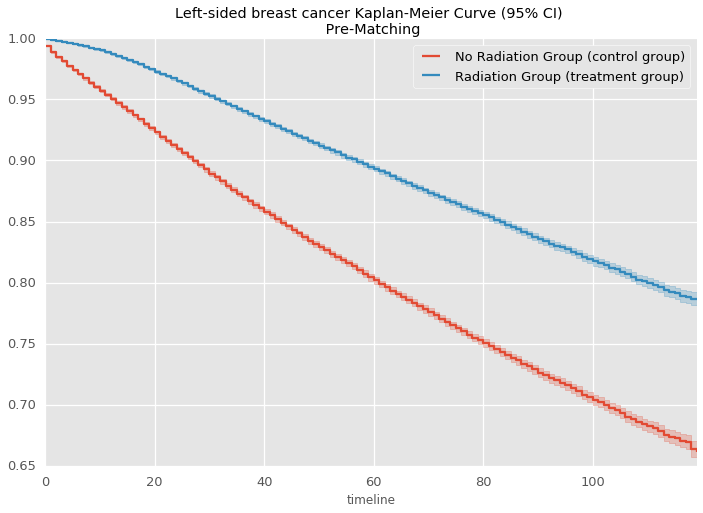

In [18]:
ax = kmfcontrol.plot()
kmftreatment.plot(ax=ax)
plt.title("Left-sided breast cancer Kaplan-Meier Curve (95% CI) \n Pre-Matching");

## <font color='steelblue'>Clearly, there is a huge benefit to receiving radiation</font>

However, one could logically argue that it is not radiation treatment that is leading to the better survival prognosis, but rather some other feature that leads to better prognosis is also leading to a greater likelihood of receiving radiation therapy. So that we are not really comparing apples to apples when we calculate these two survival curves. To answer this objection, we need to perform patient matching, so that we are really comparing apples to apples and that any marked difference in the survival curves can be confidently attributed to the posistive effects of radiation.

In [19]:
resgoodpop['YR_BRTH'] = resgoodpop['YR_BRTH'].astype('int')
resgoodpop['AGE_DX'] = resgoodpop['AGE_DX'].astype('int')
resgoodpop['CSTUMSIZ'] = resgoodpop['CSTUMSIZ'].astype('float')
resgoodpop['lat'] = resgoodpop['lat'].astype('float')
resgoodpop['lng'] = resgoodpop['lng'].astype('float')
resgoodpop['srv_time_mon'] = resgoodpop['srv_time_mon'].astype('float')

newcolumns = list(resgoodpop.columns)


newcolumns.remove('srv_time_mon')
newcolumns.remove('STAT_REC_Alive')
newcolumns.remove('STAT_REC_Dead')
newcolumns.remove('SEX_Female')

resgreatpop = resgoodpop[newcolumns].copy()

In [20]:
resgreatpop['PUBCSNUM'] = resgreatpop.index
leaguefilter = (resgreatpop['PUBCSNUM'].loc[treatmentindices])
resgreatpop['League'] = resgreatpop['PUBCSNUM'].isin(treatmentindices).astype('int')
del resgreatpop['PUBCSNUM']
dftree = resgreatpop.copy()

y = dftree['League'].copy()
del dftree['League']

In [21]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.multiclass import OneVsRestClassifier

import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plot
#import psycopg2
import random
from sklearn import ensemble
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.cross_validation import StratifiedShuffleSplit
import pylab as plot
from pandas import DataFrame, Series
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn import feature_extraction
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import ParameterGrid
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
#from sklearn.neural_network import MultilayerPerceptronClassifier
from sklearn.neural_network import BernoulliRBM
from sklearn.svm import SVC
import pylab as pl
from sklearn.decomposition import RandomizedPCA
from itertools import cycle
from sklearn.cross_validation import ShuffleSplit
from scipy.stats import sem
from pprint import pprint
from math import sqrt, fabs, exp
import matplotlib.pyplot as plot
from sklearn.cross_validation import train_test_split
from sklearn import ensemble
from sklearn.metrics import roc_auc_score, roc_curve
import numpy
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from pandas.tools.plotting import lag_plot

This brute force method of finding similar patients characterized by points in a high-dimensional space is possible for thsi data set as well as for Big Data sized data sets thanks to a data structure called a KDTree. In order to construct the KDTree, we first need to transform the numeric data so that all of the different features contribute equally to the euclidean distance between patients/records. For example, **AGE_DX** is on the order of 60 or so, while **YR_BRTH** is around 1960. Without standardization, **YR_BRTH** would contribute much more to the distance between patients than **AGE_DX**. the result of standardization (or Z-score normalization) is that features will be rescaled so that they will have the properties of a standard normal distribution with

$
\mu = 0$ and $\sigma = 1$

where $\mu$ is the mean (average) and $\sigma$ is the standard deviation from the mean; standard deviation scores (also called z-scores) are then calculated as follows:

$
z_{i} = \frac{x_{i} -\mu}{\sigma}
$

In [22]:
xTrain = dftree.values
xTrain = StandardScaler().fit_transform(xTrain)
from sklearn.neighbors import KDTree
print(xTrain)

[[-0.08351446 -0.34425379  0.88890672 ..., -0.44205836  0.84332737
   1.4115178 ]
 [-0.08351446 -0.34425379  0.88890672 ..., -0.39939058  0.85793605
   1.43914214]
 [-0.08351446 -0.34425379 -1.12497744 ..., -0.3567228   0.84332737
   1.4115178 ]
 ..., 
 [-0.08351446 -0.34425379  0.88890672 ..., -0.05804836 -1.51397547
   0.44581432]
 [-0.08351446 -0.34425379  0.88890672 ...,  0.83797497 -1.50646777
   0.63377969]
 [-0.08351446 -0.34425379 -1.12497744 ..., -0.69806502 -1.39163386
   0.6043983 ]]


In [23]:
from sklearn.neighbors import KDTree
kdt = KDTree(xTrain, leaf_size=30)

## <font color='steelblue'>Here is a video explaining the construction of a KDTree</font>

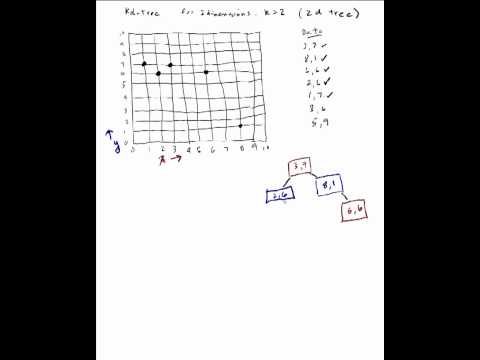

In [24]:
from IPython.display import YouTubeVideo
YouTubeVideo('LdaL-l2S76c')

In [25]:
dftreeleague = dftree.copy()
dftreeleague['League'] = y

def get_league(x):
    return dftreeleague['League'].loc[x]

dist4, ind4 = kdt.query(xTrain, k=4, return_distance=True)

### <font color='steelblue'>Finding the distances to all of the 4 nearest neighbors for each patient took about one hour. That may sound like a long time, but is nothing compared to a brute force method.

In [26]:

dftreeleague['nearest'] = pd.Series(ind4[:,0],index=dftreeleague.index)
dftreeleague['neighbor_1'] = pd.Series(ind4[:,1],index=dftreeleague.index)
dftreeleague['neighbor_2'] = pd.Series(ind4[:,2],index=dftreeleague.index)
dftreeleague['neighbor_3'] = pd.Series(ind4[:,3],index=dftreeleague.index)
dftreeleague['distance_1'] = pd.Series(dist4[:,1],index=dftreeleague.index)
dftreeleague['distance_2'] = pd.Series(dist4[:,2],index=dftreeleague.index)
dftreeleague['distance_3'] = pd.Series(dist4[:,3],index=dftreeleague.index)

dfmap = {v: dftreeleague.index[v] for v in range(dftreeleague.shape[0])}

In [27]:
def get_pubcsnum(x,transformationdict = dfmap):
    return dfmap[x]


dftreeleague['neighbor_1'] = dftreeleague['neighbor_1'].apply(get_pubcsnum)
dftreeleague['neighbor_2'] = dftreeleague['neighbor_2'].apply(get_pubcsnum)
dftreeleague['neighbor_3'] = dftreeleague['neighbor_3'].apply(get_pubcsnum)

def get_league(x):
    return dftreeleague['League'].loc[x]

dftreeleague['neighbor_1_League'] = dftreeleague['neighbor_1'].apply(get_league)
dftreeleague['neighbor_2_League'] = dftreeleague['neighbor_2'].apply(get_league)
dftreeleague['neighbor_3_League'] = dftreeleague['neighbor_3'].apply(get_league)

neighbor_1_match = (dftreeleague['neighbor_1_League'] == 1)

dist1filter = (dftreeleague['distance_1'] <= 4)
dist2filter = (dftreeleague['distance_2'] <= 4)
dist3filter = (dftreeleague['distance_3'] <= 4)

one = dftreeleague[['neighbor_1','distance_1',
                  'neighbor_1_League'
]][(dftreeleague['neighbor_1_League'] != dftreeleague['League']) & (neighbor_1_match) & (dist1filter)].copy()


neighbor_2_match = (dftreeleague['neighbor_2_League'] == 1)

two = dftreeleague[['neighbor_2','distance_2',
                  'neighbor_2_League'
]][(dftreeleague['neighbor_2_League'] != dftreeleague['League']) & (neighbor_2_match) & (dist2filter)].copy()


neighbor_3_match = (dftreeleague['neighbor_3_League'] == 1)

three = dftreeleague[['neighbor_3','distance_3',
                  'neighbor_3_League'
]][(dftreeleague['neighbor_3_League'] != dftreeleague['League']) & (neighbor_3_match) & (dist3filter) ].copy()

one.head(10)

,neighbor_1,distance_1,neighbor_1_League
PUBCSNUM,,,
7000515,12964756,2.914344,1
7005175,11856154,0.516635,1
7006495,93416670,0.449665,1
7009666,19861762,1.448943,1
7010913,81010126,2.948969,1
7014563,12841164,0.809157,1
7015041,52135373,2.852568,1
7017353,92098998,0.820767,1
7020773,93287117,0.692882,1


In [28]:

onedict = one['neighbor_1'].to_dict()
twodict = two['neighbor_2'].to_dict()
threedict = three['neighbor_3'].to_dict()

from collections import defaultdict

dd = defaultdict(list)

for d in (onedict, twodict):
    for key, value in d.items():
        dd[key].append(value)
        
        

goodcontrolteams = list(dd.keys())

goodtreatmentteams = list(dd.values())
matches = list(set([item for sublist in goodtreatmentteams for item in sublist]))

treatmentindices = matches
controlindices = goodcontrolteams
print(len(treatmentindices))
print(len(controlindices))

71849
80596


## <font color='steelblue'>Need to do a one-to-one matching (where each member of the control group is matched to one and only one member of the treatment group, and vice-versa</font>

In [29]:
d_one_to_one = {k: dd[k][0] for k in dd}
d_c_t = {}

for key, value in d_one_to_one.items():
    if value not in d_c_t.values():
        d_c_t[key] = value
        
controlindices = list(d_c_t.keys())
treatmentindices = list(d_c_t.values())     

In [30]:
controlindices = list(d_c_t.keys())
treatmentindices = list(d_c_t.values())

print(len(controlindices), len(treatmentindices))

56759 56759


So we have 56,759 control patients matched very closely (distance less than 4 in the high-dimensional space) to 56,759 treatment patients. This is a good-sized group and will allow us to draw definitive statistical inferences.